# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [113]:
# can comment out after executing
# !unzip processed-celeba-small.zip

In [114]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [115]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [116]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # get directories
    image_path = './' + data_dir + 'celeba/'

    # define datasets using ImageFolder
    im_dataset = datasets.ImageFolder(image_path, transform = transform)
    
    # create and return DataLoaders
    img_loader = DataLoader(im_dataset, batch_size = batch_size, shuffle=True)
    
    return img_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [117]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

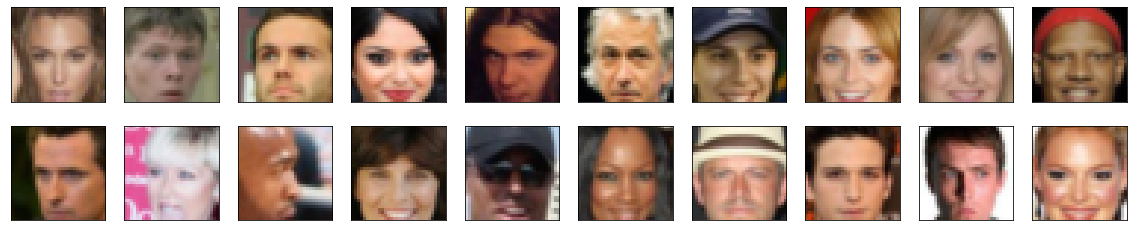

In [118]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [119]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [120]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8431)
Max:  tensor(0.7882)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [121]:
import torch.nn as nn
import torch.nn.functional as F

### Convolutional Helper Function

In [122]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Helper function derived from the GAN exercises that we worked on during this module
    """
    
    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size,
                           stride = stride, padding = padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)    

In [123]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim

        # complete init function
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 3x32x32 input, output dimx16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # dim*2x8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # dim*4x4x4
        # self.conv3 = conv(conv_dim*2, 1, 4, stride=1, batch_norm=False) # dim*4x4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, batch_norm=False)
        
        # classification layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        #x = self.conv4(x)
        x = x.view(-1, self.conv_dim*8*2*2)
        x = self.fc(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [124]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    deconv function derived from from DCGAN exercise
    """
    layers = []
    
    deconv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, padding=padding, bias=False)
    
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [125]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.z_size = z_size
        self.conv_dim = conv_dim

        # complete init function
        self.fc1 = nn.Linear(z_size, 4*4*4*conv_dim)
        self.tconv1 = deconv(4*conv_dim, 2*conv_dim, 4)
        self.tconv2 = deconv(2*conv_dim, conv_dim, 4)
        self.tconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1, 4*self.conv_dim, 4, 4)
        
        x = F.leaky_relu(self.tconv1(x))
        x = F.leaky_relu(self.tconv2(x))
        x = torch.tanh(self.tconv3(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [126]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # code from mentor help in the Knowledge base: https://knowledge.udacity.com/questions/242873
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [127]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [128]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [129]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [130]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    # need a sigmoid on the discriminator
    # use BCE loss
    
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    #BCE with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    #BCE with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [131]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, betas=[beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, betas=[beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [132]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # Zero out gradients
            d_optimizer.zero_grad()
            # compute discriminator losses on real images
            d_real = D(real_images)
            d_real_loss = real_loss(d_real, smooth=True)
            
            # create fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            # add up losses and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            

            # 2. Train the generator with an adversarial loss
            # zero gradients
            g_optimizer.zero_grad()
            
            # train with fake images and flipped labels
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # compute the discriminator losses on fake images using flipped labels
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [138]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.3922 | g_loss: 7.6011
Epoch [    1/  100] | d_loss: 0.3599 | g_loss: 4.8597
Epoch [    1/  100] | d_loss: 0.3711 | g_loss: 6.6070
Epoch [    1/  100] | d_loss: 0.3593 | g_loss: 6.2324
Epoch [    1/  100] | d_loss: 0.3525 | g_loss: 5.0839
Epoch [    1/  100] | d_loss: 0.3642 | g_loss: 6.2362
Epoch [    1/  100] | d_loss: 0.3708 | g_loss: 5.6262
Epoch [    1/  100] | d_loss: 0.3517 | g_loss: 6.8461
Epoch [    1/  100] | d_loss: 0.3522 | g_loss: 6.9873
Epoch [    1/  100] | d_loss: 0.3553 | g_loss: 5.4466
Epoch [    1/  100] | d_loss: 0.3679 | g_loss: 6.8730
Epoch [    1/  100] | d_loss: 0.3619 | g_loss: 5.8637
Epoch [    1/  100] | d_loss: 0.3623 | g_loss: 2.7400
Epoch [    1/  100] | d_loss: 0.3557 | g_loss: 7.1595
Epoch [    1/  100] | d_loss: 0.3567 | g_loss: 5.7352
Epoch [    1/  100] | d_loss: 0.3522 | g_loss: 7.0775
Epoch [    1/  100] | d_loss: 0.3414 | g_loss: 8.1747
Epoch [    1/  100] | d_loss: 0.3458 | g_loss: 6.1387
Epoch [    1/  100] | d_loss

Epoch [    5/  100] | d_loss: 0.3858 | g_loss: 6.5748
Epoch [    5/  100] | d_loss: 0.3665 | g_loss: 6.9427
Epoch [    5/  100] | d_loss: 0.3605 | g_loss: 5.7587
Epoch [    5/  100] | d_loss: 0.4391 | g_loss: 3.5416
Epoch [    5/  100] | d_loss: 0.3724 | g_loss: 6.7124
Epoch [    5/  100] | d_loss: 0.3560 | g_loss: 7.2089
Epoch [    5/  100] | d_loss: 0.3564 | g_loss: 5.9937
Epoch [    5/  100] | d_loss: 0.3675 | g_loss: 5.6571
Epoch [    5/  100] | d_loss: 0.3689 | g_loss: 5.2860
Epoch [    5/  100] | d_loss: 0.3392 | g_loss: 7.4955
Epoch [    5/  100] | d_loss: 0.4051 | g_loss: 4.9890
Epoch [    5/  100] | d_loss: 0.4206 | g_loss: 5.7676
Epoch [    5/  100] | d_loss: 0.3636 | g_loss: 6.1172
Epoch [    5/  100] | d_loss: 0.3595 | g_loss: 7.4038
Epoch [    5/  100] | d_loss: 0.3857 | g_loss: 5.6219
Epoch [    5/  100] | d_loss: 0.3865 | g_loss: 5.3176
Epoch [    5/  100] | d_loss: 0.3896 | g_loss: 7.2955
Epoch [    5/  100] | d_loss: 0.3565 | g_loss: 5.6861
Epoch [    5/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.4137 | g_loss: 4.5964
Epoch [    9/  100] | d_loss: 0.3503 | g_loss: 6.4089
Epoch [    9/  100] | d_loss: 0.3831 | g_loss: 5.5468
Epoch [    9/  100] | d_loss: 0.3740 | g_loss: 5.6918
Epoch [    9/  100] | d_loss: 0.3660 | g_loss: 4.7774
Epoch [    9/  100] | d_loss: 0.3687 | g_loss: 7.4985
Epoch [    9/  100] | d_loss: 0.3530 | g_loss: 6.3597
Epoch [    9/  100] | d_loss: 0.3529 | g_loss: 7.0088
Epoch [    9/  100] | d_loss: 0.3438 | g_loss: 5.7160
Epoch [    9/  100] | d_loss: 0.4239 | g_loss: 5.0434
Epoch [    9/  100] | d_loss: 1.0113 | g_loss: 2.2241
Epoch [    9/  100] | d_loss: 0.4673 | g_loss: 4.3869
Epoch [    9/  100] | d_loss: 0.3775 | g_loss: 6.0020
Epoch [    9/  100] | d_loss: 0.3860 | g_loss: 5.5668
Epoch [    9/  100] | d_loss: 0.3575 | g_loss: 6.7746
Epoch [    9/  100] | d_loss: 0.3632 | g_loss: 7.8600
Epoch [    9/  100] | d_loss: 0.5498 | g_loss: 4.1082
Epoch [    9/  100] | d_loss: 0.6589 | g_loss: 5.2451
Epoch [    9/  100] | d_loss

Epoch [   13/  100] | d_loss: 0.4131 | g_loss: 6.4644
Epoch [   13/  100] | d_loss: 0.3739 | g_loss: 5.8514
Epoch [   13/  100] | d_loss: 0.3516 | g_loss: 6.6730
Epoch [   13/  100] | d_loss: 0.3598 | g_loss: 5.3176
Epoch [   13/  100] | d_loss: 0.3554 | g_loss: 6.5435
Epoch [   13/  100] | d_loss: 0.3628 | g_loss: 5.3625
Epoch [   13/  100] | d_loss: 0.3496 | g_loss: 5.5958
Epoch [   13/  100] | d_loss: 0.3599 | g_loss: 5.6149
Epoch [   13/  100] | d_loss: 0.3508 | g_loss: 6.1497
Epoch [   13/  100] | d_loss: 0.3419 | g_loss: 6.8335
Epoch [   13/  100] | d_loss: 0.3836 | g_loss: 5.5813
Epoch [   13/  100] | d_loss: 0.3566 | g_loss: 4.7760
Epoch [   14/  100] | d_loss: 0.3769 | g_loss: 5.3585
Epoch [   14/  100] | d_loss: 0.3546 | g_loss: 7.2850
Epoch [   14/  100] | d_loss: 0.3427 | g_loss: 5.5039
Epoch [   14/  100] | d_loss: 0.3693 | g_loss: 4.2435
Epoch [   14/  100] | d_loss: 0.6913 | g_loss: 3.4541
Epoch [   14/  100] | d_loss: 0.5424 | g_loss: 3.2782
Epoch [   14/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.3638 | g_loss: 6.4067
Epoch [   17/  100] | d_loss: 0.3594 | g_loss: 8.6351
Epoch [   17/  100] | d_loss: 0.3761 | g_loss: 4.3763
Epoch [   17/  100] | d_loss: 0.3637 | g_loss: 5.8139
Epoch [   18/  100] | d_loss: 0.3749 | g_loss: 6.5723
Epoch [   18/  100] | d_loss: 0.3720 | g_loss: 6.5631
Epoch [   18/  100] | d_loss: 0.3713 | g_loss: 7.6543
Epoch [   18/  100] | d_loss: 0.3530 | g_loss: 6.7840
Epoch [   18/  100] | d_loss: 0.3458 | g_loss: 7.2093
Epoch [   18/  100] | d_loss: 0.3524 | g_loss: 6.0452
Epoch [   18/  100] | d_loss: 0.3855 | g_loss: 5.2426
Epoch [   18/  100] | d_loss: 0.3676 | g_loss: 5.2308
Epoch [   18/  100] | d_loss: 0.4106 | g_loss: 6.4817
Epoch [   18/  100] | d_loss: 0.3674 | g_loss: 5.2450
Epoch [   18/  100] | d_loss: 0.3579 | g_loss: 5.9854
Epoch [   18/  100] | d_loss: 0.3551 | g_loss: 7.4376
Epoch [   18/  100] | d_loss: 0.3792 | g_loss: 6.9857
Epoch [   18/  100] | d_loss: 0.3478 | g_loss: 6.6409
Epoch [   18/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.3534 | g_loss: 5.8232
Epoch [   22/  100] | d_loss: 0.3980 | g_loss: 4.3285
Epoch [   22/  100] | d_loss: 0.3440 | g_loss: 7.5561
Epoch [   22/  100] | d_loss: 0.3642 | g_loss: 6.6253
Epoch [   22/  100] | d_loss: 0.3886 | g_loss: 4.3796
Epoch [   22/  100] | d_loss: 0.3463 | g_loss: 7.0185
Epoch [   22/  100] | d_loss: 0.3507 | g_loss: 6.4946
Epoch [   22/  100] | d_loss: 0.3460 | g_loss: 6.1692
Epoch [   22/  100] | d_loss: 0.3451 | g_loss: 6.6574
Epoch [   22/  100] | d_loss: 0.3434 | g_loss: 8.1031
Epoch [   22/  100] | d_loss: 0.3591 | g_loss: 6.7960
Epoch [   22/  100] | d_loss: 0.3550 | g_loss: 6.9841
Epoch [   22/  100] | d_loss: 0.3591 | g_loss: 5.7947
Epoch [   22/  100] | d_loss: 0.3386 | g_loss: 7.1299
Epoch [   22/  100] | d_loss: 0.3550 | g_loss: 6.5791
Epoch [   22/  100] | d_loss: 0.3423 | g_loss: 8.2232
Epoch [   22/  100] | d_loss: 0.4192 | g_loss: 2.6279
Epoch [   22/  100] | d_loss: 0.3566 | g_loss: 6.9590
Epoch [   22/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.3474 | g_loss: 5.8020
Epoch [   26/  100] | d_loss: 0.3473 | g_loss: 6.0231
Epoch [   26/  100] | d_loss: 0.3519 | g_loss: 5.6083
Epoch [   26/  100] | d_loss: 0.3598 | g_loss: 8.1566
Epoch [   26/  100] | d_loss: 0.3506 | g_loss: 7.5681
Epoch [   26/  100] | d_loss: 0.3356 | g_loss: 7.6167
Epoch [   26/  100] | d_loss: 0.4918 | g_loss: 5.4747
Epoch [   26/  100] | d_loss: 0.3749 | g_loss: 5.6080
Epoch [   26/  100] | d_loss: 0.3826 | g_loss: 6.9893
Epoch [   26/  100] | d_loss: 0.3670 | g_loss: 7.3688
Epoch [   26/  100] | d_loss: 0.3577 | g_loss: 6.5625
Epoch [   26/  100] | d_loss: 0.3570 | g_loss: 7.2051
Epoch [   26/  100] | d_loss: 0.3512 | g_loss: 8.1462
Epoch [   26/  100] | d_loss: 0.4667 | g_loss: 8.0409
Epoch [   26/  100] | d_loss: 0.3530 | g_loss: 6.2122
Epoch [   26/  100] | d_loss: 0.3707 | g_loss: 5.3483
Epoch [   26/  100] | d_loss: 0.3641 | g_loss: 7.1160
Epoch [   26/  100] | d_loss: 0.3448 | g_loss: 7.2123
Epoch [   26/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.3487 | g_loss: 8.2179
Epoch [   30/  100] | d_loss: 0.3433 | g_loss: 6.3583
Epoch [   30/  100] | d_loss: 0.3643 | g_loss: 5.0261
Epoch [   30/  100] | d_loss: 0.3619 | g_loss: 5.4919
Epoch [   30/  100] | d_loss: 0.6548 | g_loss: 2.8690
Epoch [   30/  100] | d_loss: 0.6116 | g_loss: 3.0328
Epoch [   30/  100] | d_loss: 0.4973 | g_loss: 2.9921
Epoch [   30/  100] | d_loss: 0.3890 | g_loss: 5.8984
Epoch [   30/  100] | d_loss: 0.3651 | g_loss: 6.6691
Epoch [   30/  100] | d_loss: 0.3745 | g_loss: 5.6258
Epoch [   30/  100] | d_loss: 0.4261 | g_loss: 6.0928
Epoch [   30/  100] | d_loss: 0.3733 | g_loss: 5.5699
Epoch [   30/  100] | d_loss: 0.3763 | g_loss: 7.0045
Epoch [   30/  100] | d_loss: 0.4175 | g_loss: 5.7267
Epoch [   30/  100] | d_loss: 0.3576 | g_loss: 5.9802
Epoch [   30/  100] | d_loss: 0.3783 | g_loss: 6.1681
Epoch [   31/  100] | d_loss: 0.3477 | g_loss: 6.0980
Epoch [   31/  100] | d_loss: 0.3540 | g_loss: 6.5068
Epoch [   31/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.3409 | g_loss: 7.8333
Epoch [   34/  100] | d_loss: 0.3411 | g_loss: 5.7405
Epoch [   34/  100] | d_loss: 0.3538 | g_loss: 5.0497
Epoch [   34/  100] | d_loss: 0.3544 | g_loss: 5.5142
Epoch [   34/  100] | d_loss: 0.5176 | g_loss: 3.4043
Epoch [   34/  100] | d_loss: 0.3593 | g_loss: 7.3708
Epoch [   34/  100] | d_loss: 0.3744 | g_loss: 6.5950
Epoch [   34/  100] | d_loss: 0.4117 | g_loss: 3.5933
Epoch [   35/  100] | d_loss: 0.3770 | g_loss: 6.5572
Epoch [   35/  100] | d_loss: 0.3817 | g_loss: 6.5780
Epoch [   35/  100] | d_loss: 0.3530 | g_loss: 7.3866
Epoch [   35/  100] | d_loss: 0.3479 | g_loss: 7.1044
Epoch [   35/  100] | d_loss: 0.3395 | g_loss: 8.1230
Epoch [   35/  100] | d_loss: 3.7024 | g_loss: 0.1193
Epoch [   35/  100] | d_loss: 0.4433 | g_loss: 3.6564
Epoch [   35/  100] | d_loss: 0.4817 | g_loss: 4.4879
Epoch [   35/  100] | d_loss: 0.4188 | g_loss: 5.1168
Epoch [   35/  100] | d_loss: 0.4142 | g_loss: 4.4660
Epoch [   35/  100] | d_loss

Epoch [   39/  100] | d_loss: 0.4453 | g_loss: 3.2454
Epoch [   39/  100] | d_loss: 0.3937 | g_loss: 5.1553
Epoch [   39/  100] | d_loss: 0.4045 | g_loss: 5.5841
Epoch [   39/  100] | d_loss: 0.4318 | g_loss: 4.1434
Epoch [   39/  100] | d_loss: 0.7277 | g_loss: 2.2089
Epoch [   39/  100] | d_loss: 0.3776 | g_loss: 5.0725
Epoch [   39/  100] | d_loss: 0.3770 | g_loss: 5.5046
Epoch [   39/  100] | d_loss: 0.3788 | g_loss: 6.1923
Epoch [   39/  100] | d_loss: 0.3550 | g_loss: 5.8916
Epoch [   39/  100] | d_loss: 0.3486 | g_loss: 8.2349
Epoch [   39/  100] | d_loss: 0.3665 | g_loss: 9.0873
Epoch [   39/  100] | d_loss: 0.7643 | g_loss: 2.3067
Epoch [   39/  100] | d_loss: 0.3576 | g_loss: 6.1261
Epoch [   39/  100] | d_loss: 0.3487 | g_loss: 7.3080
Epoch [   39/  100] | d_loss: 0.3546 | g_loss: 5.5930
Epoch [   39/  100] | d_loss: 0.3469 | g_loss: 8.3085
Epoch [   39/  100] | d_loss: 0.3497 | g_loss: 4.4529
Epoch [   39/  100] | d_loss: 0.3772 | g_loss: 4.9519
Epoch [   39/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.3526 | g_loss: 6.4373
Epoch [   43/  100] | d_loss: 0.3612 | g_loss: 5.6950
Epoch [   43/  100] | d_loss: 0.3479 | g_loss: 8.3661
Epoch [   43/  100] | d_loss: 0.3414 | g_loss: 7.9601
Epoch [   43/  100] | d_loss: 0.3489 | g_loss: 7.3183
Epoch [   43/  100] | d_loss: 0.4282 | g_loss: 3.1522
Epoch [   43/  100] | d_loss: 0.3709 | g_loss: 5.8120
Epoch [   43/  100] | d_loss: 0.4427 | g_loss: 3.6352
Epoch [   43/  100] | d_loss: 0.3836 | g_loss: 6.4132
Epoch [   43/  100] | d_loss: 0.4140 | g_loss: 6.6471
Epoch [   43/  100] | d_loss: 0.4166 | g_loss: 5.5906
Epoch [   43/  100] | d_loss: 0.3751 | g_loss: 4.5960
Epoch [   43/  100] | d_loss: 0.3531 | g_loss: 6.7462
Epoch [   43/  100] | d_loss: 0.3629 | g_loss: 5.5448
Epoch [   43/  100] | d_loss: 0.3784 | g_loss: 7.0961
Epoch [   43/  100] | d_loss: 0.3525 | g_loss: 7.2518
Epoch [   43/  100] | d_loss: 0.3416 | g_loss: 8.2991
Epoch [   43/  100] | d_loss: 0.3554 | g_loss: 6.3679
Epoch [   43/  100] | d_loss

Epoch [   47/  100] | d_loss: 0.3386 | g_loss: 7.8105
Epoch [   47/  100] | d_loss: 0.3647 | g_loss: 5.7374
Epoch [   47/  100] | d_loss: 0.3512 | g_loss: 7.2944
Epoch [   47/  100] | d_loss: 0.3587 | g_loss: 7.3036
Epoch [   47/  100] | d_loss: 0.4013 | g_loss: 6.0704
Epoch [   47/  100] | d_loss: 0.3445 | g_loss: 8.5039
Epoch [   47/  100] | d_loss: 0.3686 | g_loss: 6.6188
Epoch [   47/  100] | d_loss: 0.3392 | g_loss: 7.9918
Epoch [   47/  100] | d_loss: 0.3430 | g_loss: 8.6255
Epoch [   47/  100] | d_loss: 0.3521 | g_loss: 7.0437
Epoch [   47/  100] | d_loss: 0.3469 | g_loss: 6.9711
Epoch [   47/  100] | d_loss: 0.3473 | g_loss: 9.1006
Epoch [   47/  100] | d_loss: 0.4302 | g_loss: 7.6833
Epoch [   47/  100] | d_loss: 0.6230 | g_loss: 1.2822
Epoch [   47/  100] | d_loss: 0.4432 | g_loss: 4.5691
Epoch [   47/  100] | d_loss: 0.3889 | g_loss: 6.1306
Epoch [   47/  100] | d_loss: 0.3621 | g_loss: 6.5647
Epoch [   47/  100] | d_loss: 0.3929 | g_loss: 3.7454
Epoch [   47/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.3438 | g_loss: 7.5754
Epoch [   51/  100] | d_loss: 0.3447 | g_loss: 5.8568
Epoch [   51/  100] | d_loss: 0.3868 | g_loss: 4.8117
Epoch [   51/  100] | d_loss: 0.3481 | g_loss: 6.5030
Epoch [   51/  100] | d_loss: 0.3730 | g_loss: 3.1503
Epoch [   51/  100] | d_loss: 0.3487 | g_loss: 6.0716
Epoch [   51/  100] | d_loss: 0.3666 | g_loss: 5.6000
Epoch [   51/  100] | d_loss: 0.3608 | g_loss: 7.5009
Epoch [   51/  100] | d_loss: 0.3627 | g_loss: 5.4959
Epoch [   51/  100] | d_loss: 0.3532 | g_loss: 5.8042
Epoch [   51/  100] | d_loss: 0.3417 | g_loss: 6.3058
Epoch [   51/  100] | d_loss: 0.3541 | g_loss: 9.7657
Epoch [   52/  100] | d_loss: 0.3505 | g_loss: 5.4609
Epoch [   52/  100] | d_loss: 0.4166 | g_loss: 4.7605
Epoch [   52/  100] | d_loss: 0.3478 | g_loss: 5.3117
Epoch [   52/  100] | d_loss: 0.3584 | g_loss: 8.4832
Epoch [   52/  100] | d_loss: 0.3451 | g_loss: 5.4867
Epoch [   52/  100] | d_loss: 0.3396 | g_loss: 7.1822
Epoch [   52/  100] | d_loss

Epoch [   55/  100] | d_loss: 0.3530 | g_loss: 6.3838
Epoch [   55/  100] | d_loss: 0.3353 | g_loss: 8.3372
Epoch [   55/  100] | d_loss: 0.7297 | g_loss: 4.7677
Epoch [   55/  100] | d_loss: 0.3852 | g_loss: 3.9159
Epoch [   56/  100] | d_loss: 0.3848 | g_loss: 6.7647
Epoch [   56/  100] | d_loss: 0.5632 | g_loss: 2.5284
Epoch [   56/  100] | d_loss: 0.3688 | g_loss: 6.1748
Epoch [   56/  100] | d_loss: 0.3926 | g_loss: 5.6424
Epoch [   56/  100] | d_loss: 0.3545 | g_loss: 5.9430
Epoch [   56/  100] | d_loss: 0.3528 | g_loss: 8.0210
Epoch [   56/  100] | d_loss: 0.3474 | g_loss: 6.1893
Epoch [   56/  100] | d_loss: 0.3451 | g_loss: 4.8878
Epoch [   56/  100] | d_loss: 0.3400 | g_loss: 7.7302
Epoch [   56/  100] | d_loss: 0.3417 | g_loss: 7.2440
Epoch [   56/  100] | d_loss: 0.3446 | g_loss: 7.5203
Epoch [   56/  100] | d_loss: 0.3500 | g_loss: 6.0947
Epoch [   56/  100] | d_loss: 0.3406 | g_loss: 7.3067
Epoch [   56/  100] | d_loss: 0.3598 | g_loss: 6.7355
Epoch [   56/  100] | d_loss

Epoch [   60/  100] | d_loss: 0.3525 | g_loss: 6.6241
Epoch [   60/  100] | d_loss: 0.3476 | g_loss: 6.2419
Epoch [   60/  100] | d_loss: 0.3395 | g_loss: 5.8303
Epoch [   60/  100] | d_loss: 0.3912 | g_loss: 5.1235
Epoch [   60/  100] | d_loss: 0.3330 | g_loss: 7.0256
Epoch [   60/  100] | d_loss: 0.3519 | g_loss: 7.4432
Epoch [   60/  100] | d_loss: 0.3442 | g_loss: 8.2707
Epoch [   60/  100] | d_loss: 0.3509 | g_loss: 7.3254
Epoch [   60/  100] | d_loss: 0.3578 | g_loss: 6.8182
Epoch [   60/  100] | d_loss: 0.3919 | g_loss: 5.0958
Epoch [   60/  100] | d_loss: 0.3373 | g_loss: 6.9619
Epoch [   60/  100] | d_loss: 0.3425 | g_loss: 7.6500
Epoch [   60/  100] | d_loss: 0.3524 | g_loss: 12.0110
Epoch [   60/  100] | d_loss: 0.3565 | g_loss: 6.4008
Epoch [   60/  100] | d_loss: 0.3399 | g_loss: 8.6317
Epoch [   60/  100] | d_loss: 0.3389 | g_loss: 8.5750
Epoch [   60/  100] | d_loss: 0.3394 | g_loss: 6.2250
Epoch [   60/  100] | d_loss: 0.3392 | g_loss: 7.4778
Epoch [   60/  100] | d_los

Epoch [   64/  100] | d_loss: 0.3334 | g_loss: 8.7522
Epoch [   64/  100] | d_loss: 0.3411 | g_loss: 7.9280
Epoch [   64/  100] | d_loss: 0.3370 | g_loss: 10.5741
Epoch [   64/  100] | d_loss: 0.3476 | g_loss: 7.6438
Epoch [   64/  100] | d_loss: 0.3401 | g_loss: 7.7493
Epoch [   64/  100] | d_loss: 0.3312 | g_loss: 8.1188
Epoch [   64/  100] | d_loss: 0.5072 | g_loss: 4.1965
Epoch [   64/  100] | d_loss: 0.4338 | g_loss: 4.1132
Epoch [   64/  100] | d_loss: 0.3743 | g_loss: 4.7447
Epoch [   64/  100] | d_loss: 0.3790 | g_loss: 5.1167
Epoch [   64/  100] | d_loss: 0.3526 | g_loss: 5.6228
Epoch [   64/  100] | d_loss: 0.3775 | g_loss: 6.0691
Epoch [   64/  100] | d_loss: 0.3581 | g_loss: 5.8862
Epoch [   64/  100] | d_loss: 0.3636 | g_loss: 5.8509
Epoch [   64/  100] | d_loss: 0.3566 | g_loss: 5.8670
Epoch [   64/  100] | d_loss: 0.3593 | g_loss: 4.4479
Epoch [   64/  100] | d_loss: 0.3455 | g_loss: 7.6575
Epoch [   64/  100] | d_loss: 0.3659 | g_loss: 5.0172
Epoch [   64/  100] | d_los

Epoch [   68/  100] | d_loss: 0.3491 | g_loss: 8.4770
Epoch [   68/  100] | d_loss: 0.3324 | g_loss: 8.5472
Epoch [   68/  100] | d_loss: 0.3357 | g_loss: 8.1374
Epoch [   68/  100] | d_loss: 0.3314 | g_loss: 8.5592
Epoch [   68/  100] | d_loss: 0.3330 | g_loss: 7.3582
Epoch [   68/  100] | d_loss: 0.3333 | g_loss: 9.7845
Epoch [   68/  100] | d_loss: 0.3389 | g_loss: 6.7087
Epoch [   68/  100] | d_loss: 0.3292 | g_loss: 8.3518
Epoch [   68/  100] | d_loss: 0.3389 | g_loss: 7.0922
Epoch [   68/  100] | d_loss: 0.3429 | g_loss: 10.4054
Epoch [   68/  100] | d_loss: 1.2930 | g_loss: 2.0501
Epoch [   68/  100] | d_loss: 0.3579 | g_loss: 4.8137
Epoch [   68/  100] | d_loss: 0.3594 | g_loss: 4.6697
Epoch [   68/  100] | d_loss: 0.3442 | g_loss: 7.7190
Epoch [   68/  100] | d_loss: 0.3438 | g_loss: 6.1532
Epoch [   68/  100] | d_loss: 0.3491 | g_loss: 6.0893
Epoch [   69/  100] | d_loss: 0.3351 | g_loss: 6.8270
Epoch [   69/  100] | d_loss: 0.3359 | g_loss: 9.1218
Epoch [   69/  100] | d_los

Epoch [   72/  100] | d_loss: 0.3326 | g_loss: 7.8880
Epoch [   72/  100] | d_loss: 0.3390 | g_loss: 7.1164
Epoch [   72/  100] | d_loss: 0.3405 | g_loss: 8.7589
Epoch [   72/  100] | d_loss: 0.3369 | g_loss: 8.8610
Epoch [   72/  100] | d_loss: 0.3677 | g_loss: 4.5568
Epoch [   72/  100] | d_loss: 0.3340 | g_loss: 6.7388
Epoch [   72/  100] | d_loss: 0.3408 | g_loss: 9.1389
Epoch [   72/  100] | d_loss: 0.3378 | g_loss: 8.0826
Epoch [   73/  100] | d_loss: 0.3307 | g_loss: 7.3569
Epoch [   73/  100] | d_loss: 0.3358 | g_loss: 9.5056
Epoch [   73/  100] | d_loss: 0.4339 | g_loss: 4.8124
Epoch [   73/  100] | d_loss: 0.3941 | g_loss: 5.7869
Epoch [   73/  100] | d_loss: 0.3816 | g_loss: 6.5194
Epoch [   73/  100] | d_loss: 0.3435 | g_loss: 8.2115
Epoch [   73/  100] | d_loss: 0.3500 | g_loss: 6.9807
Epoch [   73/  100] | d_loss: 0.3601 | g_loss: 5.5382
Epoch [   73/  100] | d_loss: 0.3407 | g_loss: 6.8353
Epoch [   73/  100] | d_loss: 0.3359 | g_loss: 8.5384
Epoch [   73/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.3380 | g_loss: 5.7327
Epoch [   77/  100] | d_loss: 0.3314 | g_loss: 8.0865
Epoch [   77/  100] | d_loss: 0.3339 | g_loss: 9.8436
Epoch [   77/  100] | d_loss: 0.3747 | g_loss: 6.5632
Epoch [   77/  100] | d_loss: 0.3488 | g_loss: 7.4754
Epoch [   77/  100] | d_loss: 0.3337 | g_loss: 7.0186
Epoch [   77/  100] | d_loss: 0.3320 | g_loss: 8.3469
Epoch [   77/  100] | d_loss: 0.3341 | g_loss: 8.4197
Epoch [   77/  100] | d_loss: 0.3366 | g_loss: 8.3934
Epoch [   77/  100] | d_loss: 0.3395 | g_loss: 7.8945
Epoch [   77/  100] | d_loss: 0.3409 | g_loss: 8.1266
Epoch [   77/  100] | d_loss: 0.3343 | g_loss: 8.4312
Epoch [   77/  100] | d_loss: 0.3399 | g_loss: 8.4487
Epoch [   77/  100] | d_loss: 0.3337 | g_loss: 7.8767
Epoch [   77/  100] | d_loss: 0.3415 | g_loss: 6.9610
Epoch [   77/  100] | d_loss: 0.6093 | g_loss: 14.2045
Epoch [   77/  100] | d_loss: 0.4132 | g_loss: 4.6675
Epoch [   77/  100] | d_loss: 0.3664 | g_loss: 3.8397
Epoch [   77/  100] | d_los

Epoch [   81/  100] | d_loss: 0.3730 | g_loss: 9.5553
Epoch [   81/  100] | d_loss: 0.3386 | g_loss: 9.1808
Epoch [   81/  100] | d_loss: 0.3380 | g_loss: 8.9498
Epoch [   81/  100] | d_loss: 0.3401 | g_loss: 7.9781
Epoch [   81/  100] | d_loss: 0.3351 | g_loss: 9.6448
Epoch [   81/  100] | d_loss: 0.3328 | g_loss: 7.8213
Epoch [   81/  100] | d_loss: 0.3481 | g_loss: 7.8090
Epoch [   81/  100] | d_loss: 0.3495 | g_loss: 9.6333
Epoch [   81/  100] | d_loss: 0.3346 | g_loss: 8.6245
Epoch [   81/  100] | d_loss: 0.3559 | g_loss: 7.6224
Epoch [   81/  100] | d_loss: 0.3563 | g_loss: 6.7234
Epoch [   81/  100] | d_loss: 0.3459 | g_loss: 8.6360
Epoch [   81/  100] | d_loss: 0.3561 | g_loss: 6.7841
Epoch [   81/  100] | d_loss: 0.3501 | g_loss: 7.5666
Epoch [   81/  100] | d_loss: 0.3366 | g_loss: 9.0585
Epoch [   81/  100] | d_loss: 0.3391 | g_loss: 8.4692
Epoch [   81/  100] | d_loss: 0.3329 | g_loss: 7.0875
Epoch [   81/  100] | d_loss: 0.3344 | g_loss: 7.5599
Epoch [   81/  100] | d_loss

Epoch [   85/  100] | d_loss: 0.3396 | g_loss: 7.2554
Epoch [   85/  100] | d_loss: 0.3386 | g_loss: 9.4175
Epoch [   85/  100] | d_loss: 0.3298 | g_loss: 8.1990
Epoch [   85/  100] | d_loss: 0.3317 | g_loss: 7.2213
Epoch [   85/  100] | d_loss: 0.3578 | g_loss: 6.1586
Epoch [   85/  100] | d_loss: 0.3330 | g_loss: 7.3399
Epoch [   85/  100] | d_loss: 0.3311 | g_loss: 8.2504
Epoch [   85/  100] | d_loss: 0.3423 | g_loss: 7.9495
Epoch [   85/  100] | d_loss: 0.3344 | g_loss: 7.4705
Epoch [   85/  100] | d_loss: 0.3389 | g_loss: 10.7446
Epoch [   85/  100] | d_loss: 0.3389 | g_loss: 8.3470
Epoch [   85/  100] | d_loss: 0.3561 | g_loss: 7.6972
Epoch [   85/  100] | d_loss: 0.3457 | g_loss: 8.6952
Epoch [   85/  100] | d_loss: 0.3548 | g_loss: 7.0852
Epoch [   85/  100] | d_loss: 0.3489 | g_loss: 7.1589
Epoch [   85/  100] | d_loss: 0.3354 | g_loss: 8.2784
Epoch [   85/  100] | d_loss: 0.3473 | g_loss: 7.0048
Epoch [   85/  100] | d_loss: 0.3367 | g_loss: 8.0069
Epoch [   85/  100] | d_los

Epoch [   89/  100] | d_loss: 0.4949 | g_loss: 3.4121
Epoch [   89/  100] | d_loss: 0.3890 | g_loss: 5.1762
Epoch [   89/  100] | d_loss: 0.3922 | g_loss: 5.9745
Epoch [   89/  100] | d_loss: 0.4130 | g_loss: 3.2465
Epoch [   89/  100] | d_loss: 0.4342 | g_loss: 3.0553
Epoch [   89/  100] | d_loss: 0.3483 | g_loss: 7.2660
Epoch [   89/  100] | d_loss: 0.3518 | g_loss: 7.5198
Epoch [   89/  100] | d_loss: 0.3483 | g_loss: 7.5399
Epoch [   89/  100] | d_loss: 0.3416 | g_loss: 6.7228
Epoch [   89/  100] | d_loss: 0.3358 | g_loss: 8.0145
Epoch [   89/  100] | d_loss: 0.3408 | g_loss: 8.5267
Epoch [   89/  100] | d_loss: 0.3334 | g_loss: 8.7693
Epoch [   90/  100] | d_loss: 0.3427 | g_loss: 7.0295
Epoch [   90/  100] | d_loss: 0.3337 | g_loss: 9.7405
Epoch [   90/  100] | d_loss: 0.3604 | g_loss: 10.1177
Epoch [   90/  100] | d_loss: 0.3434 | g_loss: 7.7953
Epoch [   90/  100] | d_loss: 0.3363 | g_loss: 7.0498
Epoch [   90/  100] | d_loss: 0.3451 | g_loss: 6.2666
Epoch [   90/  100] | d_los

Epoch [   93/  100] | d_loss: 0.3533 | g_loss: 5.6367
Epoch [   93/  100] | d_loss: 0.4226 | g_loss: 7.0061
Epoch [   93/  100] | d_loss: 0.3383 | g_loss: 5.7846
Epoch [   93/  100] | d_loss: 0.3403 | g_loss: 9.1279
Epoch [   94/  100] | d_loss: 0.3430 | g_loss: 7.4943
Epoch [   94/  100] | d_loss: 0.3432 | g_loss: 5.6733
Epoch [   94/  100] | d_loss: 0.3348 | g_loss: 6.5218
Epoch [   94/  100] | d_loss: 0.3340 | g_loss: 8.7982
Epoch [   94/  100] | d_loss: 0.3331 | g_loss: 10.0402
Epoch [   94/  100] | d_loss: 0.3377 | g_loss: 7.1101
Epoch [   94/  100] | d_loss: 0.3350 | g_loss: 6.9588
Epoch [   94/  100] | d_loss: 0.3381 | g_loss: 7.1711
Epoch [   94/  100] | d_loss: 0.3758 | g_loss: 7.0586
Epoch [   94/  100] | d_loss: 0.3410 | g_loss: 9.7569
Epoch [   94/  100] | d_loss: 0.3869 | g_loss: 6.0787
Epoch [   94/  100] | d_loss: 0.3460 | g_loss: 6.4055
Epoch [   94/  100] | d_loss: 0.3393 | g_loss: 9.3889
Epoch [   94/  100] | d_loss: 0.3418 | g_loss: 8.2938
Epoch [   94/  100] | d_los

Epoch [   98/  100] | d_loss: 0.3833 | g_loss: 5.2017
Epoch [   98/  100] | d_loss: 0.3521 | g_loss: 7.5299
Epoch [   98/  100] | d_loss: 0.3697 | g_loss: 9.4007
Epoch [   98/  100] | d_loss: 0.3563 | g_loss: 8.8155
Epoch [   98/  100] | d_loss: 0.3659 | g_loss: 6.9586
Epoch [   98/  100] | d_loss: 0.3355 | g_loss: 10.2033
Epoch [   98/  100] | d_loss: 0.3467 | g_loss: 8.0319
Epoch [   98/  100] | d_loss: 0.3425 | g_loss: 7.6745
Epoch [   98/  100] | d_loss: 0.3460 | g_loss: 7.7566
Epoch [   98/  100] | d_loss: 0.3383 | g_loss: 8.6221
Epoch [   98/  100] | d_loss: 0.3289 | g_loss: 8.8312
Epoch [   98/  100] | d_loss: 0.3337 | g_loss: 8.0137
Epoch [   98/  100] | d_loss: 0.3858 | g_loss: 4.6813
Epoch [   98/  100] | d_loss: 0.3850 | g_loss: 6.8579
Epoch [   98/  100] | d_loss: 0.3528 | g_loss: 6.8163
Epoch [   98/  100] | d_loss: 0.3386 | g_loss: 8.0357
Epoch [   98/  100] | d_loss: 0.3755 | g_loss: 6.5877
Epoch [   98/  100] | d_loss: 0.3579 | g_loss: 7.7668
Epoch [   98/  100] | d_los

/state/partition1/llgrid/pkg/anaconda/anaconda3-2020b/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

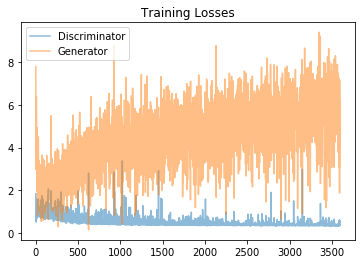

In [134]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [135]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [136]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

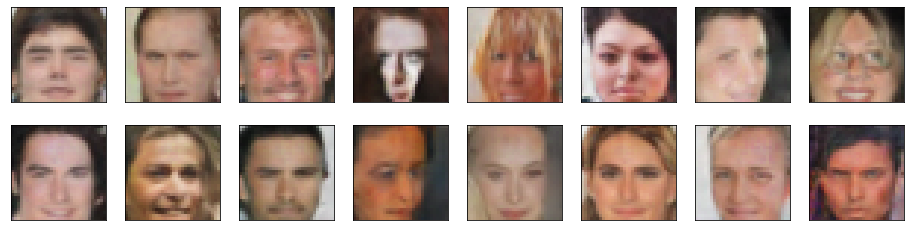

In [137]:
_ = view_samples(-1, samples)

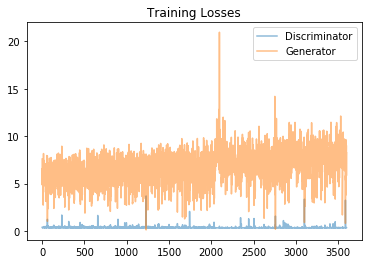

In [139]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [140]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

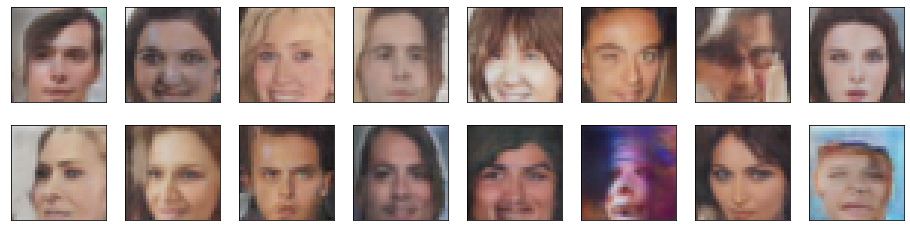

In [141]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.